# Introduction
This notebook will be used for training the classification model on CUHK - Compcars Dataset.

In [1]:
!rm -rf /kaggle/working/*

# 1. Import Libraries
- Import Google drive and kaggle for dataset integration.
- Import PyTorch and assisting DeepLearning Libraries.
- Import OpenCV 2 for Image processing and manipulation.

# 1.1. Importing PyTorch and Assisting Libraries.

In [2]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cachetools-6.2.1


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
import io
from datetime import datetime
from typing import Dict, Any, List, Tuple, Optional
from collections import Counter
from glob import glob
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2

import mlflow
import mlflow.pytorch
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

from tqdm import tqdm

## 1.3. MLflow specific libraries

In [4]:
import mlflow
import mlflow.pytorch
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
import io
import json
from datetime import datetime

# 2. Importing Dataset.
The **CUHK-SYSU CompCars Dataset** is a comprehensive car dataset that provides a large collection of car images and their attributes. It is primarily used for fine-grained visual classification and vehicle attribute recognition.

Key features of the dataset include:

*   **Diversity**: It contains data from two scenarios:
    *   **Web-supervised data**: Over 163,000 images of 795 car models from the web, with hierarchical make-model-year annotations.
    *   **Surveillance data**: Over 50,000 images of 1,716 car models captured from surveillance cameras in various scenes, with bounding boxes and view angles.
*   **Detailed Annotations**: Each car image is annotated with various attributes such as:
    *   Make and model
    *   Year of manufacture
    *   Car type (e.g., sedan, SUV, truck)
    *   Maximum speed
    *   Displacement
    *   Number of doors
    *   Number of seats
*   **Purpose**: The dataset is designed to facilitate research in:
    *   Fine-grained car recognition
    *   Vehicle attribute prediction
    *   Cross-domain learning (web to surveillance)
    *   Car re-identification

It's a valuable resource for researchers and developers working on intelligent transportation systems, autonomous driving, and computer vision applications related to vehicles.

In [5]:
# Downloaded CompCars Kaggle Dataset Location
path = "/kaggle/input/compcars"  
print(f"The dataset Path: {path}")

The dataset Path: /kaggle/input/compcars


In [6]:
os.listdir(path)

['label', 'part', 'train_test_split', 'misc', 'image']

# 3. Dataset Loader and Augmentations.

# 3.1. Creating Dataset Loader.

## Purpose
This dataset loader loads and processes the **CompCars** (Comprehensive Cars) dataset for multi-task learning, specifically designed to predict three vehicle attributes simultaneously:
- **Make** (manufacturer/brand)
- **Model** (specific vehicle model)  
- **Year** (manufacturing year)

## Dataset Structure
The dataset follows this directory hierarchy:

```bash
data_root/
├── image/
│ ├── {make_id}/ # Manufacturer ID (e.g., 1, 2, 3...)
│ │ ├── {model_id}/ # Model ID (e.g., 101, 102, 103...)
│ │ │ ├── {year}/ # Manufacturing year or "unknown"
│ │ │ │ └── *.jpg # Vehicle images
└── misc/
└── make_model_name.mat # MAT file with human-readable label mappings
```


## Key Processing Steps
1. **Image Loading**: Recursively scans all JPG images from the nested directory structure
2. **Path Parsing**: Extracts make, model, and year labels from the directory path
3. **Data Filtering**: Removes models with only one sample to ensure proper training
4. **Label Encoding**: Converts categorical labels to numerical indices for all three tasks
5. **Multi-task Setup**: Prepares the dataset for simultaneous prediction of make, model, and year
6. **Train/Test Split**: Provides stratified splitting based on model labels to maintain class distribution

In [7]:
class CompCarsMultiTaskDataset(Dataset):
    def __init__(self, data_root, transform=None, load_label_mappings=True,
                 default_unknown_year=2015):
        """
        Unified CompCars Multi-Task Dataset
        """
        self.data_root = data_root
        self.transform = transform
        self.default_unknown_year = default_unknown_year

        self.image_paths = []
        self.make_labels = []
        self.model_labels = []
        self.year_labels = []

        self._load_dataset()
        self._filter_single_sample_classes()
        self._setup_multi_task_encoding()

        if load_label_mappings:
            self._load_label_mappings()

    def _load_dataset(self):
        """Load all images from the Kaggle CompCars structure"""
        image_base_path = os.path.join(self.data_root, 'image')

        print(f"Loading images from: {image_base_path}")

        image_pattern = os.path.join(image_base_path, '*', '*', '*', '*.jpg')
        all_images = glob(image_pattern)

        print(f"Found {len(all_images)} total images")

        if not all_images:
            raise ValueError(f"No images found with pattern: {image_pattern}")

        unknown_year_count = 0
        valid_images_count = 0

        for image_path in all_images:
            path_parts = image_path.split(os.sep)

            try:
                make_id = int(path_parts[-4])
                model_id = int(path_parts[-3])

                year_str = path_parts[-2]
                if year_str.isdigit():
                    year_id = int(year_str)
                else:
                    year_id = self.default_unknown_year
                    unknown_year_count += 1

                self.image_paths.append(image_path)
                self.make_labels.append(make_id)
                self.model_labels.append(model_id)
                self.year_labels.append(year_id)
                valid_images_count += 1

            except (ValueError, IndexError) as e:
                continue

        print(f"Successfully loaded {valid_images_count} images")
        if unknown_year_count > 0:
            print(f"Used default year {self.default_unknown_year} for {unknown_year_count} images with 'unknown' year")

    def _filter_single_sample_classes(self):
        """Filter out models with only 1 sample"""
        model_counts = Counter(self.model_labels)
        single_sample_models = [model for model, count in model_counts.items() if count == 1]

        if single_sample_models:
            print(f"Found {len(single_sample_models)} models with only 1 sample. Filtering them out...")

            filtered_indices = []
            for i, model_label in enumerate(self.model_labels):
                if model_label not in single_sample_models:
                    filtered_indices.append(i)

            self.image_paths = [self.image_paths[i] for i in filtered_indices]
            self.make_labels = [self.make_labels[i] for i in filtered_indices]
            self.model_labels = [self.model_labels[i] for i in filtered_indices]
            self.year_labels = [self.year_labels[i] for i in filtered_indices]

            print(f"After filtering: {len(self.image_paths)} images")

    def _setup_multi_task_encoding(self):
        """Setup label encoding for all three tasks"""
        self.make_encoder = LabelEncoder()
        self.encoded_makes = self.make_encoder.fit_transform(self.make_labels)
        self.num_makes = len(self.make_encoder.classes_)

        self.model_encoder = LabelEncoder()
        self.encoded_models = self.model_encoder.fit_transform(self.model_labels)
        self.num_models = len(self.model_encoder.classes_)

        self.year_encoder = LabelEncoder()
        self.encoded_years = self.year_encoder.fit_transform(self.year_labels)
        self.num_years = len(self.year_encoder.classes_)

        print(f"Multi-task classes:")
        print(f"  - Makes: {self.num_makes} classes")
        print(f"  - Models: {self.num_models} classes")
        print(f"  - Years: {self.num_years} classes")

        self._print_class_distribution()

    def _print_class_distribution(self):
        """Print distribution statistics for all tasks"""
        make_unique, make_counts = np.unique(self.encoded_makes, return_counts=True)
        model_unique, model_counts = np.unique(self.encoded_models, return_counts=True)
        year_unique, year_counts = np.unique(self.encoded_years, return_counts=True)

        print(f"Class distribution:")
        print(f"  Makes: {make_counts.min()}-{make_counts.max()} images per class")
        print(f"  Models: {model_counts.min()}-{model_counts.max()} images per class")
        print(f"  Years: {year_counts.min()}-{year_counts.max()} images per class")

    def _load_label_mappings(self):
        """Load meaningful label names from MAT files"""
        try:
            label_path = os.path.join(self.data_root, 'misc')
            make_model_mat = sio.loadmat(os.path.join(label_path, 'make_model_name.mat'))

            self.make_names = {}
            make_data = make_model_mat['make_names']
            for i in range(len(make_data)):
                if len(make_data[i]) > 0:
                    self.make_names[i+1] = str(make_data[i][0])

            self.model_names = {}
            model_data = make_model_mat['model_names']
            for i in range(len(model_data)):
                if len(model_data[i]) > 0:
                    self.model_names[i+1] = str(model_data[i][0])

            print(f"Loaded {len(self.make_names)} make names and {len(self.model_names)} model names")

        except Exception as e:
            print(f"Could not load label mappings: {e}")
            self.make_names = None
            self.model_names = None

    def create_train_test_split(self, test_size=0.2, random_state=42):
        """Create train and test subsets with consistent labels"""
        print(f"Creating {test_size*100}% test split...")

        # Split indices
        train_idx, test_idx = train_test_split(
            range(len(self.image_paths)),
            test_size=test_size,
            random_state=random_state,
            stratify=self.model_labels
        )

        # Create subsets
        train_subset = Subset(self, train_idx)
        test_subset = Subset(self, test_idx)

        print(f"Train set: {len(train_idx)} images")
        print(f"Test set: {len(test_idx)} images")

        return train_subset, test_subset

    def get_label_name(self, label_id, label_type):
        """Get human-readable label name"""
        if label_type == 'make' and hasattr(self, 'make_names') and self.make_names:
            return self.make_names.get(label_id, f"Make_{label_id}")
        elif label_type == 'model' and hasattr(self, 'model_names') and self.model_names:
            return self.model_names.get(label_id, f"Model_{label_id}")
        elif label_type == 'year':
            return f"Year_{label_id}"
        else:
            return str(label_id)

    def get_original_label(self, encoded_label, label_type):
        """Convert encoded label back to original label ID"""
        if label_type == 'make':
            return self.make_encoder.inverse_transform([encoded_label])[0]
        elif label_type == 'model':
            return self.model_encoder.inverse_transform([encoded_label])[0]
        elif label_type == 'year':
            return self.year_encoder.inverse_transform([encoded_label])[0]
        else:
            return encoded_label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            from PIL import Image
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, {
                'make': torch.tensor(self.encoded_makes[idx], dtype=torch.long),
                'model': torch.tensor(self.encoded_models[idx], dtype=torch.long),
                'year': torch.tensor(self.encoded_years[idx], dtype=torch.long),
                'image_path': image_path
            }

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            if self.transform:
                image = torch.zeros(3, 224, 224)
            else:
                image = Image.new('RGB', (224, 224))

            return image, {
                'make': torch.tensor(0, dtype=torch.long),
                'model': torch.tensor(0, dtype=torch.long),
                'year': torch.tensor(0, dtype=torch.long),
                'image_path': image_path
            }

# 3.2. Augmentations.
## What These Do
They prepare car images for the computer to learn from.

## Training Transforms
**For learning:** Makes the model better at recognizing cars in different conditions
- **Resize**: Makes all images the same size (224x224 pixels)
- **Random Flip**: Sometimes flips images sideways (like mirror)
- **Color Change**: Slightly changes brightness and contrast
- **Convert**: Changes images to numbers the computer understands
- **Normalize**: Adjusts colors to common standards

## Validation Transforms  
**For testing:** Keeps images consistent to measure progress accurately
- **Resize**: Same size as training (224x224 pixels)
- **Convert**: Changes images to numbers
- **Normalize**: Same color adjustment as training

## Why Different?
- **Training**: Adds variety so model learns better
- **Validation**: Keeps things consistent for fair testing

In [8]:
# Train Transforms
train_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.15, contrast=0.15),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation Transforms
val_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 3.3. Train/Val Datasets & Dataloaders

In [9]:
# Create the unified dataset
full_dataset = CompCarsMultiTaskDataset(
    data_root=path,
    transform=None,  # No transform at dataset level
    default_unknown_year=2015
)

# Create train/test splits using indices only
train_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.model_labels
)

print(f"Train indices: {len(train_indices)}")
print(f"Test indices: {len(test_indices)}")

# Create datasets with transforms applied in __getitem__
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the actual index
        actual_idx = self.indices[idx]

        # Get the data from base dataset
        image, labels = self.base_dataset[actual_idx]

        # Apply transform if provided
        if self.transform:
            image = self.transform(image)

        return image, labels

# Create train and validation datasets
train_dataset = TransformedDataset(full_dataset, train_indices, train_transform)
val_dataset = TransformedDataset(full_dataset, test_indices, val_transforms)

# Create dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True,
                              pin_memory=True,
                              persistent_workers=False,
                              num_workers=0
                              )
val_dataloader = DataLoader(val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True,
                            persistent_workers=False
                            )

Loading images from: /kaggle/input/compcars/image
Found 136726 total images
Successfully loaded 136726 images
Used default year 2015 for 343 images with 'unknown' year
Found 6 models with only 1 sample. Filtering them out...
After filtering: 136720 images
Multi-task classes:
  - Makes: 163 classes
  - Models: 1710 classes
  - Years: 26 classes
Class distribution:
  Makes: 2-5720 images per class
  Models: 2-303 images per class
  Years: 3-29324 images per class
Loaded 163 make names and 2004 model names
Train indices: 109376
Test indices: 27344


# 3.4. Visualizing Train/Test Datasets
This functions purpose is to:
1. Visualize the Dataset by printing the car image with the labels attached to it like Make, Model, and Year.
2. Test the Dataloaders to make sure they are working correctly.

Visualizing training batch...


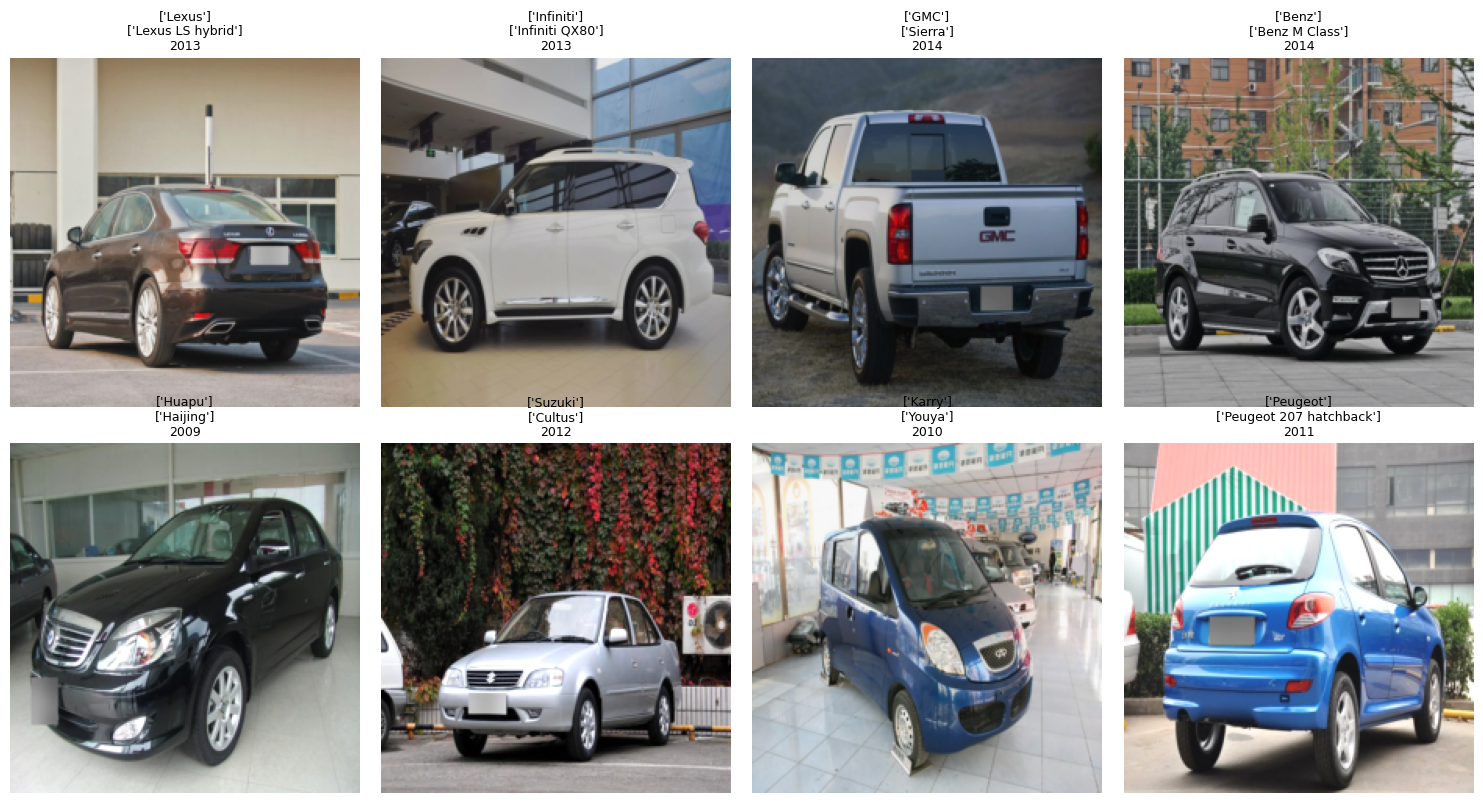

Visualizing validation batch...


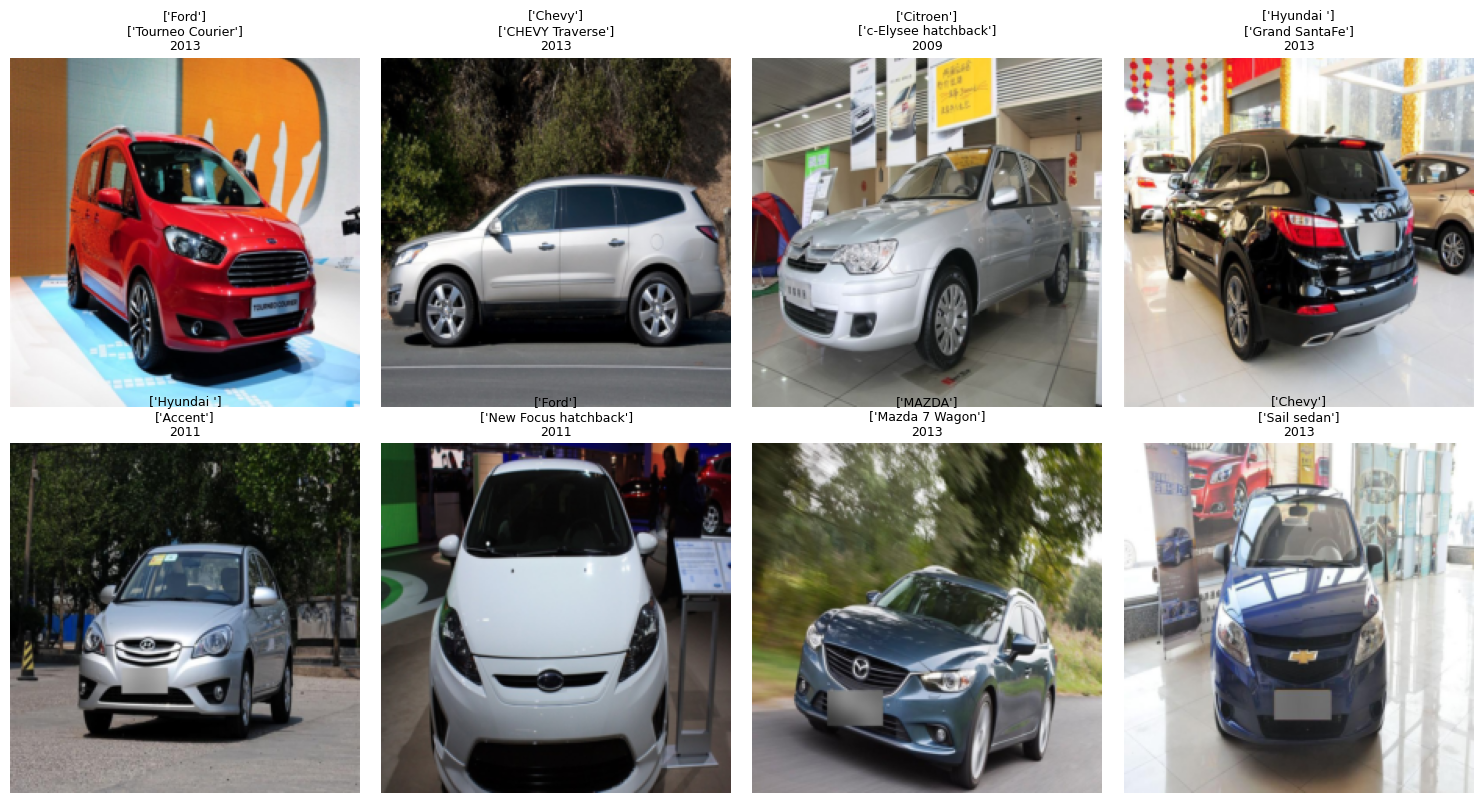

In [10]:
# Function to visualize the datasets
def visualize_batch(dataloader, dataset, num_images=8):
    """Visualize a batch of images with their labels"""
    # Get one batch
    images, labels = next(iter(dataloader))

    # Denormalize if needed (assuming ImageNet stats)
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        return tensor * std + mean

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # Denormalize and convert to numpy
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Get label names
        make_id = dataset.get_original_label(labels['make'][i].item(), 'make')
        model_id = dataset.get_original_label(labels['model'][i].item(), 'model')
        year_id = dataset.get_original_label(labels['year'][i].item(), 'year')

        make_name = dataset.get_label_name(make_id, 'make')
        model_name = dataset.get_label_name(model_id, 'model')

        # Plot
        axes[i].imshow(img)
        axes[i].set_title(f"{make_name}\n{model_name}\n{year_id}", fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Test visualization
print("Visualizing training batch...")
visualize_batch(train_dataloader, full_dataset)

print("Visualizing validation batch...")
visualize_batch(val_dataloader, full_dataset)

# 4. Model Building

In [11]:
class MultiTaskCarClassifier(nn.Module):
    """
    Multi-task car classification model with separate heads for make, model, and year prediction.
    Uses a pretrained ResNet50 backbone with custom classification heads.
    """
    
    def __init__(self, 
                 num_makes: int, 
                 num_models: int, 
                 num_years: int, 
                 pretrained: bool = True,
                 backbone: str = "resnet50"):
        """
        Initialize the multi-task classifier.
        
        Args:
            num_makes: Number of car make classes
            num_models: Number of car model classes  
            num_years: Number of car year classes
            pretrained: Whether to use pretrained ImageNet weights
            backbone: Backbone architecture ('resnet50' or 'efficientnet_b0')
        """
        super(MultiTaskCarClassifier, self).__init__()
        
        self.num_makes = num_makes
        self.num_models = num_models
        self.num_years = num_years
        self.backbone_name = backbone
        
        # Initialize backbone with pretrained weights
        if backbone == "resnet50":
            self.backbone = models.resnet50(pretrained=pretrained)
            # Remove the original classification head
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove final fully connected layer
            
        elif backbone == "efficientnet_b0":
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove classification head
        else:
            raise ValueError(f"Unsupported backbone: {backbone}. Choose 'resnet50' or 'efficientnet_b0'")
        
        # Initialize separate classification heads
        self.make_head = self._create_classification_head(self.feature_dim, num_makes)
        self.model_head = self._create_classification_head(self.feature_dim, num_models)
        self.year_head = self._create_classification_head(self.feature_dim, num_years)
        
        # Initialize weights for the new heads
        self._initialize_heads()
        
    def _create_classification_head(self, in_features: int, out_features: int) -> nn.Sequential:
        """
        Create a classification head with dropout and batch normalization.
        
        Args:
            in_features: Input feature dimension
            out_features: Output class dimension
            
        Returns:
            Sequential layer representing the classification head
        """
        return nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(512, out_features)
        )
    
    def _initialize_heads(self):
        """Initialize weights for the classification heads using Kaiming initialization."""
        for head in [self.make_head, self.model_head, self.year_head]:
            for module in head.modules():
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
    
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward pass of the multi-task model.
        
        Args:
            x: Input tensor of shape (batch_size, 3, 224, 224)
            
        Returns:
            Dictionary containing logits for each task:
            - 'make': Tensor of shape (batch_size, num_makes)
            - 'model': Tensor of shape (batch_size, num_models) 
            - 'year': Tensor of shape (batch_size, num_years)
        """
        # Extract features from backbone
        features = self.backbone(x)  # shape: (batch_size, feature_dim)
        
        # Pass features through each classification head
        make_logits = self.make_head(features)
        model_logits = self.model_head(features)
        year_logits = self.year_head(features)
        
        return {
            'make': make_logits,
            'model': model_logits, 
            'year': year_logits
        }
    
    def get_feature_dim(self) -> int:
        """Get the feature dimension of the backbone."""
        return self.feature_dim
    
    def freeze_backbone(self):
        """Freeze backbone parameters to only train classification heads."""
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def unfreeze_backbone(self):
        """Unfreeze backbone parameters for fine-tuning."""
        for param in self.backbone.parameters():
            param.requires_grad = True

# 5. MLflow Implementation and Checkpointing

In [12]:
# MLflow Logging class
class MLflowLogger:
    """
    MLflow logging and model checkpointing utilities for multi-task car classification.
    """
    
    def __init__(self, experiment_name: str = "car_multi_task_classification"):
        """
        Initialize MLflow logger.
        
        Args:
            experiment_name: Name of the MLflow experiment
        """
        self.experiment_name = experiment_name
        self.setup_mlflow()
        
    def setup_mlflow(self):
        """Setup MLflow experiment and tracking."""
        mlflow.set_experiment(self.experiment_name)
        
    def log_epoch_metrics(self, 
                         epoch: int,
                         train_metrics: Dict[str, float],
                         val_metrics: Dict[str, float],
                         predictions: Dict[str, Tuple[np.ndarray, np.ndarray]],
                         label_encoders: Dict[str, Any],
                         artifact_path: str = "epoch_plots") -> None:
        """
        Log comprehensive metrics and artifacts for a training epoch to MLflow.
        
        Args:
            epoch: Current epoch number
            train_metrics: Dictionary containing training metrics
            val_metrics: Dictionary containing validation metrics  
            predictions: Dictionary with ground truths and predictions for each task
            label_encoders: Dictionary containing label encoders for make, model, year
            artifact_path: Path to save artifacts in MLflow
        """
        # Don't create nested runs - just log to the current active run
        # Combine all metrics for logging
        all_metrics = {}
        all_metrics.update({f"train_{k}": v for k, v in train_metrics.items()})
        all_metrics.update({f"val_{k}": v for k, v in val_metrics.items()})
        all_metrics["epoch"] = epoch
        
        # Log scalar metrics
        mlflow.log_metrics(all_metrics, step=epoch)
        
        # Generate and log confusion matrices for Make and Year (skip Model due to high cardinality)
        self._log_confusion_matrices(predictions, label_encoders, epoch, artifact_path)
        
        # Log model signature on first epoch
        if epoch == 0:
            self._log_model_signature()
    
    def _log_confusion_matrices(self, 
                              predictions: Dict[str, Tuple[np.ndarray, np.ndarray]],
                              label_encoders: Dict[str, Any],
                              epoch: int,
                              artifact_path: str) -> None:
        """
        Generate and log confusion matrices for Make and Year tasks.
        
        Args:
            predictions: Dictionary with (y_true, y_pred) for each task
            label_encoders: Label encoders for class names
            epoch: Current epoch for naming
            artifact_path: Path to save artifacts
        """
        tasks_to_plot = ['make', 'year']  # Skip 'model' due to high cardinality
        
        for task in tasks_to_plot:
            if task in predictions:
                y_true, y_pred = predictions[task]
                
                # Calculate accuracy for this specific task
                task_accuracy = accuracy_score(y_true, y_pred)
                mlflow.log_metric(f"val_{task}_accuracy", task_accuracy, step=epoch)
                
                # Create confusion matrix
                cm = confusion_matrix(y_true, y_pred, normalize='true')
                
                # Get class labels if available
                if hasattr(label_encoders[task], 'classes_'):
                    class_labels = label_encoders[task].classes_
                    # Limit to top 20 classes for readability if too many
                    if len(class_labels) > 20:
                        class_labels = class_labels[:20]
                        cm = cm[:20, :20]
                else:
                    class_labels = list(range(len(np.unique(y_true))))
                
                # Create plot
                plt.figure(figsize=(12, 10))
                sns.heatmap(cm, 
                           annot=True, 
                           fmt='.2f', 
                           cmap='Blues',
                           xticklabels=class_labels,
                           yticklabels=class_labels,
                           cbar_kws={'label': 'Normalized Accuracy'})
                
                plt.title(f'Confusion Matrix - {task.capitalize()} (Epoch {epoch})\nAccuracy: {task_accuracy:.4f}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                
                # Log to MLflow
                mlflow.log_figure(plt.gcf(), f"{artifact_path}/confusion_matrix_{task}_epoch_{epoch}.png")
                plt.close()
    
    def _log_model_signature(self) -> None:
        """
        Define and log MLflow model signature for input and output schema.
        
        The signature defines the expected input shape and output structure
        for the multi-task classification model.
        """
        try:
            # Input schema: batch of RGB images (batch_size, 3, 224, 224)
            input_schema = Schema([
                TensorSpec(np.dtype(np.float32), (-1, 3, 224, 224), "input_image")
            ])
            
            # Output schema: dictionary with logits for each task
            # FIXED: Correct output schema to match actual model output
            output_schema = Schema([
                TensorSpec(np.dtype(np.float32), (-1, -1), "make_logits"),
                TensorSpec(np.dtype(np.float32), (-1, -1), "model_logits"), 
                TensorSpec(np.dtype(np.float32), (-1, -1), "year_logits")
            ])
            
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Log signature description
            mlflow.log_text(
                json.dumps({
                    "input_description": "Batch of RGB car images normalized with ImageNet statistics",
                    "output_description": "Dictionary containing logits for make, model, and year classification",
                    "input_shape": "(-1, 3, 224, 224) where -1 is batch size",
                    "output_shapes": {
                        "make_logits": "(-1, num_makes)",
                        "model_logits": "(-1, num_models)", 
                        "year_logits": "(-1, num_years)"
                    }
                }), 
                "model_signature_description.json"
            )
            print("Model signature logged successfully")
        except Exception as e:
            print(f"Warning: Could not log model signature: {e}")

def save_model_checkpoint(model: nn.Module,
                         optimizer: torch.optim.Optimizer,
                         epoch: int,
                         save_dir: str,
                         label_encoders: Dict[str, Any],
                         metrics: Optional[Dict[str, float]] = None,
                         save_frequency: int = 3) -> str:
    """
    Save model checkpoint with comprehensive state including label mappings.
    
    WHY: Saving label mappings is critical for future inference because:
    - Allows decoding predictions without needing the original dataset
    - Preserves class-to-index mappings that may change if retraining
    - Enables standalone model deployment without dependency on training data
    - Maintains consistency between training and inference label spaces
    
    Args:
        model: PyTorch model instance
        optimizer: Optimizer instance
        epoch: Current epoch number
        save_dir: Directory to save checkpoints
        label_encoders: Dictionary containing make, model, year label encoders
        metrics: Optional dictionary of current metrics
        save_frequency: Save checkpoint every N epochs (default: 3)
        
    Returns:
        Path to saved checkpoint file
    """
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Only save every save_frequency epochs (default every 3rd epoch)
    if epoch % save_frequency != 0 and epoch > 0:
        return ""
    
    # Prepare checkpoint data
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'label_mappings': {
            'make': {
                'classes': label_encoders['make'].classes_.tolist() if hasattr(label_encoders['make'], 'classes_') else None,
                'type': str(type(label_encoders['make']))
            },
            'model': {
                'classes': label_encoders['model'].classes_.tolist() if hasattr(label_encoders['model'], 'classes_') else None,
                'type': str(type(label_encoders['model']))
            },
            'year': {
                'classes': label_encoders['year'].classes_.tolist() if hasattr(label_encoders['year'], 'classes_') else None,
                'type': str(type(label_encoders['year']))
            }
        },
        'model_architecture': {
            'num_makes': model.num_makes,
            'num_models': model.num_models, 
            'num_years': model.num_years,
            'backbone': model.backbone_name
        },
        'timestamp': datetime.now().isoformat()
    }
    
    # Add metrics if provided
    if metrics:
        checkpoint['metrics'] = metrics
    
    # Generate checkpoint filename
    checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pth")
    
    # Save checkpoint
    torch.save(checkpoint, checkpoint_path)
    
    # Log checkpoint info to MLflow
    try:
        mlflow.log_artifact(checkpoint_path, "checkpoints")
        mlflow.log_metric("checkpoint_saved", epoch, step=epoch)
    except Exception as e:
        print(f"Warning: Could not log checkpoint to MLflow: {e}")
    
    print(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

def load_model_checkpoint(checkpoint_path: str, 
                         model: nn.Module,
                         optimizer: Optional[torch.optim.Optimizer] = None) -> Dict[str, Any]:
    """
    Load model checkpoint and return comprehensive state.
    
    Args:
        checkpoint_path: Path to checkpoint file
        model: Model instance to load state into
        optimizer: Optional optimizer instance to load state into
        
    Returns:
        Dictionary containing checkpoint data
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state if provided
    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"Checkpoint loaded: {checkpoint_path}")
    print(f"Resuming from epoch: {checkpoint['epoch']}")
    
    return checkpoint

def log_final_model(model: nn.Module,
                   label_encoders: Dict[str, Any],
                   model_name: str = "multi_task_car_classifier") -> None:
    """
    Log final trained model to MLflow with all necessary metadata.
    
    Args:
        model: Trained PyTorch model
        label_encoders: Dictionary containing label encoders
        model_name: Name for the logged model
    """
    # Create model metadata
    metadata = {
        "model_type": "MultiTaskCarClassifier",
        "backbone": model.backbone_name,
        "num_makes": model.num_makes,
        "num_models": model.num_models,
        "num_years": model.num_years,
        "timestamp": datetime.now().isoformat(),
        "label_mappings": {
            "make_classes": label_encoders['make'].classes_.tolist() if hasattr(label_encoders['make'], 'classes_') else None,
            "model_classes": label_encoders['model'].classes_.tolist() if hasattr(label_encoders['model'], 'classes_') else None,
            "year_classes": label_encoders['year'].classes_.tolist() if hasattr(label_encoders['year'], 'classes_') else None,
        }
    }
    
    # Log model with metadata
    try:
        mlflow.pytorch.log_model(
            model,
            artifact_path=model_name,
            registered_model_name=model_name,
            metadata=metadata
        )
        
        # Log label encoders as JSON
        mlflow.log_dict(metadata, "model_metadata.json")
        
        print(f"Final model logged to MLflow as: {model_name}")
    except Exception as e:
        print(f"Error logging final model to MLflow: {e}")

# 6. Model Training

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import numpy as np
from typing import Dict, Tuple, List, Optional
import time
from tqdm import tqdm

def train_multi_task_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    label_encoders: Dict[str, Any],
    mlflow_logger: MLflowLogger,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 10,
    checkpoint_dir: str = "checkpoints",
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> Dict[str, List[float]]:
    """
    Train the multi-task car classification model with comprehensive logging and monitoring.
    
    Args:
        model: MultiTaskCarClassifier instance
        train_dataloader: Training data loader
        val_dataloader: Validation data loader
        label_encoders: Dictionary containing make, model, year label encoders
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        weight_decay: Weight decay for optimizer
        early_stopping_patience: Early stopping patience
        checkpoint_dir: Directory to save checkpoints
        device: Device to train on ('cuda' or 'cpu')
        
    Returns:
        Dictionary containing training history
    """
    # Move model to device
    model = model.to(device)
    print(f"Training on device: {device}")
    
    # Define loss functions for each task
    criterion = {
        'make': nn.CrossEntropyLoss(),
        'model': nn.CrossEntropyLoss(), 
        'year': nn.CrossEntropyLoss()
    }
    
    # Define loss weights (you can adjust these based on task importance)
    loss_weights = {
        'make': 1.0,
        'model': 1.0,
        'year': 0.8  # Slightly lower weight for year prediction
    }
    
    # Initialize optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_make_acc': [],
        'val_make_acc': [],
        'train_model_acc': [],
        'val_model_acc': [],
        'train_year_acc': [],
        'val_year_acc': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_epoch = 0
    
    # Freeze backbone for first few epochs (optional)
    print("Freezing backbone for first 5 epochs...")
    model.freeze_backbone()
    
    print("Starting training...")
    print(f"{'Epoch':^6} | {'Train Loss':^12} | {'Val Loss':^12} | {'Make Acc':^8} | {'Model Acc':^9} | {'Year Acc':^8} | {'LR':^10}")
    print("-" * 80)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Unfreeze backbone after 5 epochs for fine-tuning
        if epoch == 5:
            print("Unfreezing backbone for fine-tuning...")
            model.unfreeze_backbone()
        
        # Training phase
        model.train()
        train_metrics = train_epoch(
            model, train_dataloader, criterion, loss_weights, optimizer, device
        )
        
        # Validation phase
        model.eval()
        val_metrics, predictions = validate_epoch(
            model, val_dataloader, criterion, loss_weights, device
        )
        
        # Update learning rate
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        
        # Update history
        history['train_loss'].append(train_metrics['total_loss'])
        history['val_loss'].append(val_metrics['total_loss'])
        history['train_make_acc'].append(train_metrics['make_accuracy'])
        history['val_make_acc'].append(val_metrics['make_accuracy'])
        history['train_model_acc'].append(train_metrics['model_accuracy'])
        history['val_model_acc'].append(val_metrics['model_accuracy'])
        history['train_year_acc'].append(train_metrics['year_accuracy'])
        history['val_year_acc'].append(val_metrics['year_accuracy'])
        history['learning_rates'].append(current_lr)
        
        # Log to MLflow
        mlflow_logger.log_epoch_metrics(
            epoch=epoch,
            train_metrics=train_metrics,
            val_metrics=val_metrics,
            predictions=predictions,
            label_encoders=label_encoders
        )
        
        # Save checkpoint
        checkpoint_metrics = {
            'train_loss': train_metrics['total_loss'],
            'val_loss': val_metrics['total_loss'],
            'val_make_acc': val_metrics['make_accuracy'],
            'val_model_acc': val_metrics['model_accuracy'],
            'val_year_acc': val_metrics['year_accuracy']
        }
        
        save_model_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            save_dir=checkpoint_dir,
            label_encoders=label_encoders,
            metrics=checkpoint_metrics
        )
        
        # Print progress
        epoch_time = time.time() - start_time
        print(f"{epoch:6d} | {train_metrics['total_loss']:12.4f} | {val_metrics['total_loss']:12.4f} | "
              f"{val_metrics['make_accuracy']:8.4f} | {val_metrics['model_accuracy']:9.4f} | "
              f"{val_metrics['year_accuracy']:8.4f} | {current_lr:10.2e}")
        
        # Early stopping check
        if val_metrics['total_loss'] < best_val_loss:
            best_val_loss = val_metrics['total_loss']
            best_epoch = epoch
            early_stopping_counter = 0
            
            # Save best model
            torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pth")
            print(f"New best model saved! Val Loss: {best_val_loss:.4f}")
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
    
    # Log final model to MLflow
    log_final_model(model, label_encoders, "multi_task_car_classifier_efficientnet")
    
    print(f"\nTraining completed! Best model at epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
    
    return history

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: Dict[str, nn.Module],
    loss_weights: Dict[str, float],
    optimizer: torch.optim.Optimizer,
    device: str
) -> Dict[str, float]:
    """
    Train for one epoch.
    
    Returns:
        Dictionary containing training metrics
    """
    model.train()
    
    total_loss = 0.0
    make_loss_total = 0.0
    model_loss_total = 0.0
    year_loss_total = 0.0
    
    make_correct = 0
    model_correct = 0
    year_correct = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device)
        make_labels = labels['make'].to(device)
        model_labels = labels['model'].to(device)
        year_labels = labels['year'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate individual losses
        make_loss = criterion['make'](outputs['make'], make_labels)
        model_loss = criterion['model'](outputs['model'], model_labels)
        year_loss = criterion['year'](outputs['year'], year_labels)
        
        # Track individual losses
        make_loss_total += make_loss.item() * images.size(0)
        model_loss_total += model_loss.item() * images.size(0)
        year_loss_total += year_loss.item() * images.size(0)
        
        # Weighted total loss
        total_batch_loss = (
            loss_weights['make'] * make_loss +
            loss_weights['model'] * model_loss +
            loss_weights['year'] * year_loss
        )
        
        # Backward pass
        total_batch_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Calculate metrics
        batch_size = images.size(0)
        total_loss += total_batch_loss.item() * batch_size
        
        # Calculate predictions and accuracies
        make_pred = outputs['make'].argmax(dim=1)
        model_pred = outputs['model'].argmax(dim=1)
        year_pred = outputs['year'].argmax(dim=1)
        
        make_correct += (make_pred == make_labels).sum().item()
        model_correct += (model_pred == model_labels).sum().item()
        year_correct += (year_pred == year_labels).sum().item()
        
        total_samples += batch_size
        
        # Calculate current batch accuracies
        make_acc = (make_pred == make_labels).float().mean().item()
        model_acc = (model_pred == model_labels).float().mean().item()
        year_acc = (year_pred == year_labels).float().mean().item()
        
        # Update progress bar with ALL metrics
        progress_bar.set_postfix({
            'Loss': f"{total_batch_loss.item():.4f}",
            'Make Acc': f"{make_acc:.4f}",
            'Model Acc': f"{model_acc:.4f}",
            'Year Acc': f"{year_acc:.4f}"
        })
    
    # Calculate epoch metrics
    epoch_loss = total_loss / total_samples
    make_loss_avg = make_loss_total / total_samples
    model_loss_avg = model_loss_total / total_samples
    year_loss_avg = year_loss_total / total_samples
    
    make_accuracy = make_correct / total_samples
    model_accuracy = model_correct / total_samples
    year_accuracy = year_correct / total_samples
    
    return {
        'total_loss': epoch_loss,
        'make_loss': make_loss_avg,
        'model_loss': model_loss_avg,
        'year_loss': year_loss_avg,
        'make_accuracy': make_accuracy,
        'model_accuracy': model_accuracy,
        'year_accuracy': year_accuracy
    }

def validate_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: Dict[str, nn.Module],
    loss_weights: Dict[str, float],
    device: str
) -> Tuple[Dict[str, float], Dict[str, Tuple[np.ndarray, np.ndarray]]]:
    """
    Validate for one epoch.
    
    Returns:
        Tuple of (validation metrics, predictions dictionary)
    """
    model.eval()
    
    total_loss = 0.0
    make_loss_total = 0.0
    model_loss_total = 0.0
    year_loss_total = 0.0
    
    make_correct = 0
    model_correct = 0
    year_correct = 0
    total_samples = 0
    
    # Store predictions for confusion matrices
    all_make_true = []
    all_make_pred = []
    all_model_true = []
    all_model_pred = []
    all_year_true = []
    all_year_pred = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            # Move data to device
            images = images.to(device)
            make_labels = labels['make'].to(device)
            model_labels = labels['model'].to(device)
            year_labels = labels['year'].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate individual losses
            make_loss = criterion['make'](outputs['make'], make_labels)
            model_loss = criterion['model'](outputs['model'], model_labels)
            year_loss = criterion['year'](outputs['year'], year_labels)
            
            # Track individual losses
            make_loss_total += make_loss.item() * images.size(0)
            model_loss_total += model_loss.item() * images.size(0)
            year_loss_total += year_loss.item() * images.size(0)
            
            # Weighted total loss
            total_batch_loss = (
                loss_weights['make'] * make_loss +
                loss_weights['model'] * model_loss +
                loss_weights['year'] * year_loss
            )
            
            # Calculate metrics
            batch_size = images.size(0)
            total_loss += total_batch_loss.item() * batch_size
            
            # Calculate predictions
            make_pred = outputs['make'].argmax(dim=1)
            model_pred = outputs['model'].argmax(dim=1)
            year_pred = outputs['year'].argmax(dim=1)
            
            make_correct += (make_pred == make_labels).sum().item()
            model_correct += (model_pred == model_labels).sum().item()
            year_correct += (year_pred == year_labels).sum().item()
            
            total_samples += batch_size
            
            # Calculate current batch accuracies
            make_acc = (make_pred == make_labels).float().mean().item()
            model_acc = (model_pred == model_labels).float().mean().item()
            year_acc = (year_pred == year_labels).float().mean().item()
            
            # Store predictions for confusion matrices
            all_make_true.extend(make_labels.cpu().numpy())
            all_make_pred.extend(make_pred.cpu().numpy())
            all_model_true.extend(model_labels.cpu().numpy())
            all_model_pred.extend(model_pred.cpu().numpy())
            all_year_true.extend(year_labels.cpu().numpy())
            all_year_pred.extend(year_pred.cpu().numpy())
            
            # Update progress bar with ALL metrics
            progress_bar.set_postfix({
                'Loss': f"{total_batch_loss.item():.4f}",
                'Make Acc': f"{make_acc:.4f}",
                'Model Acc': f"{model_acc:.4f}",
                'Year Acc': f"{year_acc:.4f}"
            })
    
    # Calculate epoch metrics
    epoch_loss = total_loss / total_samples
    make_loss_avg = make_loss_total / total_samples
    model_loss_avg = model_loss_total / total_samples
    year_loss_avg = year_loss_total / total_samples
    
    make_accuracy = make_correct / total_samples
    model_accuracy = model_correct / total_samples
    year_accuracy = year_correct / total_samples
    
    # Prepare predictions for confusion matrices
    predictions = {
        'make': (np.array(all_make_true), np.array(all_make_pred)),
        'model': (np.array(all_model_true), np.array(all_model_pred)),
        'year': (np.array(all_year_true), np.array(all_year_pred))
    }
    
    metrics = {
        'total_loss': epoch_loss,
        'make_loss': make_loss_avg,
        'model_loss': model_loss_avg,
        'year_loss': year_loss_avg,
        'make_accuracy': make_accuracy,
        'model_accuracy': model_accuracy,
        'year_accuracy': year_accuracy
    }
    
    return metrics, predictions

def plot_training_history(history: Dict[str, List[float]]) -> None:
    """
    Plot training history.
    
    Args:
        history: Training history dictionary
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot make accuracy
    axes[0, 1].plot(history['train_make_acc'], label='Train Make Acc')
    axes[0, 1].plot(history['val_make_acc'], label='Val Make Acc')
    axes[0, 1].set_title('Make Classification Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot model accuracy
    axes[1, 0].plot(history['train_model_acc'], label='Train Model Acc')
    axes[1, 0].plot(history['val_model_acc'], label='Val Model Acc')
    axes[1, 0].set_title('Model Classification Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot year accuracy
    axes[1, 1].plot(history['train_year_acc'], label='Train Year Acc')
    axes[1, 1].plot(history['val_year_acc'], label='Val Year Acc')
    axes[1, 1].set_title('Year Classification Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 191MB/s]
2025/11/26 21:28:41 INFO mlflow.tracking.fluent: Experiment with name 'car_multi_task_efficientnet' does not exist. Creating a new experiment.


Model initialized with EfficientNet-B0 backbone
Number of parameters: 6,952,423
Task dimensions - Makes: 163, Models: 1710, Years: 26
Training on device: cuda
Freezing backbone for first 5 epochs...
Starting training...
Epoch  |  Train Loss  |   Val Loss   | Make Acc | Model Acc | Year Acc |     LR    
--------------------------------------------------------------------------------


Model signature logged successfully
Checkpoint saved: ./kaggle/working/checkpoint_epoch_0.pth
     0 |      12.4947 |       9.2192 |   0.2382 |    0.1961 |   0.2795 |   1.00e-03
New best model saved! Val Loss: 9.2192


     1 |       9.3542 |       8.2116 |   0.2844 |    0.2877 |   0.3016 |   9.85e-04
New best model saved! Val Loss: 8.2116


     2 |       8.5713 |       7.7058 |   0.3154 |    0.3345 |   0.3137 |   9.43e-04
New best model saved! Val Loss: 7.7058


Checkpoint saved: ./kaggle/working/checkpoint_epoch_3.pth
     3 |       8.1174 |       7.4202 |   0.3315 |    0.3656 |   0.3265 |   8.74e-04
New best model saved! Val Loss: 7.4202


     4 |       7.7828 |       7.1670 |   0.3532 |    0.3942 |   0.3353 |   7.84e-04
New best model saved! Val Loss: 7.1670
Unfreezing backbone for fine-tuning...


     5 |       5.3153 |       3.5187 |   0.7163 |    0.7036 |   0.4174 |   6.78e-04
New best model saved! Val Loss: 3.5187


Checkpoint saved: ./kaggle/working/checkpoint_epoch_6.pth
     6 |       3.1990 |       2.4650 |   0.8291 |    0.8054 |   0.4881 |   5.61e-04
New best model saved! Val Loss: 2.4650


     7 |       2.1957 |       1.8632 |   0.8897 |    0.8678 |   0.5545 |   4.40e-04
New best model saved! Val Loss: 1.8632


     8 |       1.5864 |       1.5493 |   0.9158 |    0.8946 |   0.6119 |   3.23e-04
New best model saved! Val Loss: 1.5493


Checkpoint saved: ./kaggle/working/checkpoint_epoch_9.pth
     9 |       1.1821 |       1.3496 |   0.9320 |    0.9107 |   0.6479 |   2.17e-04
New best model saved! Val Loss: 1.3496


    10 |       0.9183 |       1.2272 |   0.9405 |    0.9216 |   0.6804 |   1.27e-04
New best model saved! Val Loss: 1.2272


    11 |       0.7480 |       1.1546 |   0.9457 |    0.9277 |   0.6935 |   5.82e-05
New best model saved! Val Loss: 1.1546


2025/11/27 03:42:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Checkpoint saved: ./kaggle/working/checkpoint_epoch_12.pth
    12 |       0.6691 |       1.1311 |   0.9478 |    0.9295 |   0.6987 |   1.55e-05
New best model saved! Val Loss: 1.1311


2025/11/27 03:42:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/27 03:42:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/27 03:42:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'multi_t

Final model logged to MLflow as: multi_task_car_classifier_efficientnet

Training completed! Best model at epoch 12 with val_loss: 1.1311


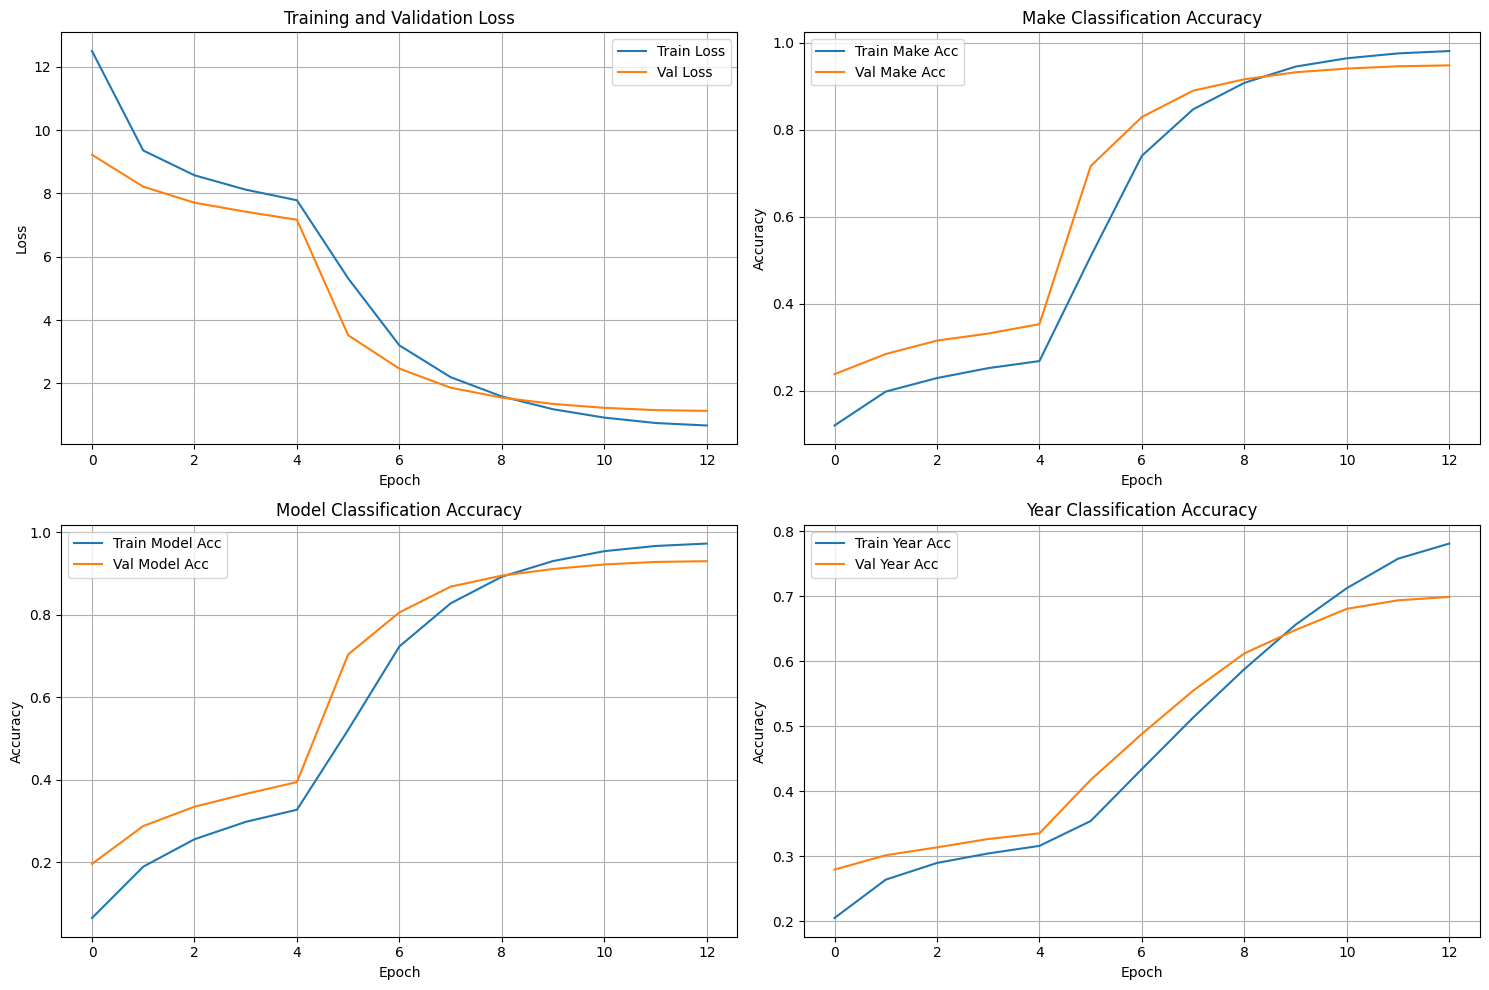

Training completed successfully!


In [14]:
# Initialize and Train the model Main Function
def main():
    """
    Main training function.
    """
    # Get label encoders from dataset
    label_encoders = {
        'make': full_dataset.make_encoder,
        'model': full_dataset.model_encoder,
        'year': full_dataset.year_encoder
    }
    
    # Initialize model with EfficientNet-B0 backbone
    model = MultiTaskCarClassifier(
        num_makes=full_dataset.num_makes,
        num_models=full_dataset.num_models,
        num_years=full_dataset.num_years,
        pretrained=True,
        backbone="efficientnet_b0"
    )
    
    print(f"Model initialized with EfficientNet-B0 backbone")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Task dimensions - Makes: {model.num_makes}, Models: {model.num_models}, Years: {model.num_years}")
    
    # Initialize MLflow logger
    mlflow_logger = MLflowLogger(experiment_name="car_multi_task_efficientnet")
    
    # Start a single MLflow run for the entire training
    with mlflow.start_run(run_name="efficientnet_b0_training"):
        # Log hyperparameters
        mlflow.log_params({
            "backbone": "efficientnet_b0",
            "num_makes": model.num_makes,
            "num_models": model.num_models,
            "num_years": model.num_years,
            "batch_size": 64,
            "learning_rate": 1e-3,
            "weight_decay": 1e-4,
            "num_epochs": 13
        })
        
        # Train the model
        history = train_multi_task_model(
            model=model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            label_encoders=label_encoders,
            mlflow_logger=mlflow_logger,
            num_epochs=13,
            learning_rate=1e-3,
            weight_decay=1e-4,
            early_stopping_patience=10,
            checkpoint_dir="./kaggle/working"
        )
        
        # Plot training history
        plot_training_history(history)
        
        print("Training completed successfully!")

if __name__=="__main__":
    main()

## 6.1. Saving The model for future inference

In [ ]:
def save_complete_model(model: nn.Module, 
                       label_encoders: Dict[str, Any],
                       save_path: str,
                       model_metadata: Optional[Dict[str, Any]] = None) -> str:
    """
    Save complete trained model with everything needed for inference.
    
    Args:
        model: Trained PyTorch model
        label_encoders: Dictionary containing make, model, year label encoders
        save_path: Path where to save the model (.pth file)
        model_metadata: Optional additional metadata to save
        
    Returns:
        Path to the saved model file
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
    
    # Prepare complete model package
    model_package = {
        # Model architecture info
        'model_architecture': {
            'num_makes': model.num_makes,
            'num_models': model.num_models,
            'num_years': model.num_years,
            'backbone': model.backbone_name,
            'model_class': model.__class__.__name__
        },
        
        # Model weights
        'model_state_dict': model.state_dict(),
        
        # Label encoders (critical for inference)
        'label_encoders': {
            'make': {
                'classes': label_encoders['make'].classes_.tolist() if hasattr(label_encoders['make'], 'classes_') else None,
                'class_to_index': dict(zip(label_encoders['make'].classes_, range(len(label_encoders['make'].classes_)))) if hasattr(label_encoders['make'], 'classes_') else None
            },
            'model': {
                'classes': label_encoders['model'].classes_.tolist() if hasattr(label_encoders['model'], 'classes_') else None,
                'class_to_index': dict(zip(label_encoders['model'].classes_, range(len(label_encoders['model'].classes_)))) if hasattr(label_encoders['model'], 'classes_') else None
            },
            'year': {
                'classes': label_encoders['year'].classes_.tolist() if hasattr(label_encoders['year'], 'classes_') else None,
                'class_to_index': dict(zip(label_encoders['year'].classes_, range(len(label_encoders['year'].classes_)))) if hasattr(label_encoders['year'], 'classes_') else None
            }
        },
        
        # Timestamp and version info
        'timestamp': datetime.now().isoformat(),
        'version': '1.0'
    }
    
    # Add optional metadata
    if model_metadata:
        model_package['metadata'] = model_metadata
    
    # Save the complete package
    torch.save(model_package, save_path)
    
    print(f"Complete model saved to: {save_path}")
    print(f"Model info: {model.num_makes} makes, {model.num_models} models, {model.num_years} years")
    print(f"Backbone: {model.backbone_name}")
    
    return save_path

# Simple usage example:
def save_current_model(model, save_path = "./saved_models/complete_model.pth"):
    """
    Simple function to save the current trained model with all label encoders.
    """
    # Get label encoders from dataset
    label_encoders = {
        'make': full_dataset.make_encoder,
        'model': full_dataset.model_encoder,
        'year': full_dataset.year_encoder
    }
    
    # Save the complete model
    save_complete_model(
        model=model,
        label_encoders=label_encoders,
        save_path=save_path,
        model_metadata={
            'training_notes': 'Trained on CompCars dataset',
            'image_size': 224,
            'normalization': 'ImageNet stats'
        }
    )

In [ ]:
# Save the model
save_current_model(model, save_path = "./kaggle/working/complete_model.pth")

# 7. Conclusion